In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

csvPath = "data/"
file1 = "spi_global_rankings_intl.csv"
file2 = "spi_global_rankings.csv"
file3 = "spi_matches.csv"

df_intl  = pd.DataFrame(pd.read_csv(csvPath + file1))
df_rank  = pd.DataFrame(pd.read_csv(csvPath + file2))
df_match = pd.DataFrame(pd.read_csv(csvPath + file3))


In [2]:
print(df_intl.head())
print('***********')
print(df_rank.head())
print('***********')
print(df_match.head())

   rank       name    confed   off   def    spi
0     1      Spain      UEFA  3.38  0.58  90.79
1     2     Brazil  CONMEBOL  2.91  0.37  90.65
2     3    Germany      UEFA  3.11  0.59  88.78
3     4    Belgium      UEFA  2.95  0.56  87.97
4     5  Argentina  CONMEBOL  2.57  0.42  86.98
***********
   rank  prev_rank                 name                    league   off   def  \
0     1          1      Manchester City   Barclays Premier League  3.34  0.24   
1     2          2            Liverpool   Barclays Premier League  2.95  0.28   
2     3          3        Bayern Munich         German Bundesliga  3.29  0.46   
3     4          4  Paris Saint-Germain            French Ligue 1  2.88  0.47   
4     5          7          Real Madrid  Spanish Primera Division  2.79  0.46   

     spi  
0  95.24  
1  92.96  
2  92.43  
3  89.55  
4  88.98  
***********
         date  league_id                   league           team1  \
0  2016-08-12       1843           French Ligue 1          Bastia 

# Find the connection between league and national team

If more than one league, use the better one.
'Barclays Premier League'  England
'German Bundesliga'        Germany
'French Ligue 1'           France
'Spanish Primera Division' Spain
'Italy Serie A'            Italy
'Brasileiro Série A'       Brazil

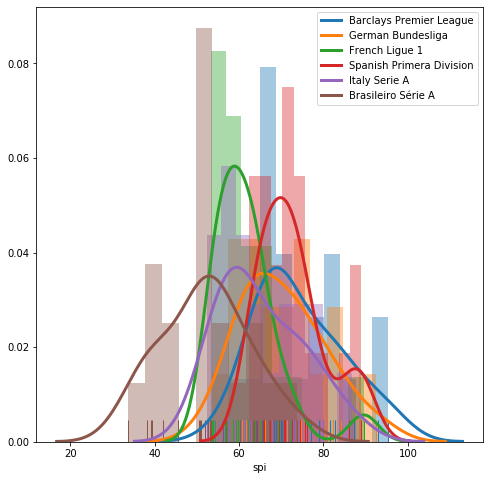

In [3]:
leagues = ['Barclays Premier League', 
           'German Bundesliga', 
           'French Ligue 1',
           'Spanish Primera Division',
           'Italy Serie A',
           'Brasileiro Série A']
plt.figure(figsize=(8, 8))
for a in leagues:
    sns.distplot(df_rank[df_rank['league']==a]['spi'], bins=10, kde=True, rug=True,
                 kde_kws={"lw": 3, "label": a})


Interesting...Brazil is famous for their soccer stars but the Brasileiro Série A seems not as strong as others.
Now let's look at the natianal team.

[Text(0, 0.5, ''), (0, 100), Text(0.5, 0, 'SPI')]

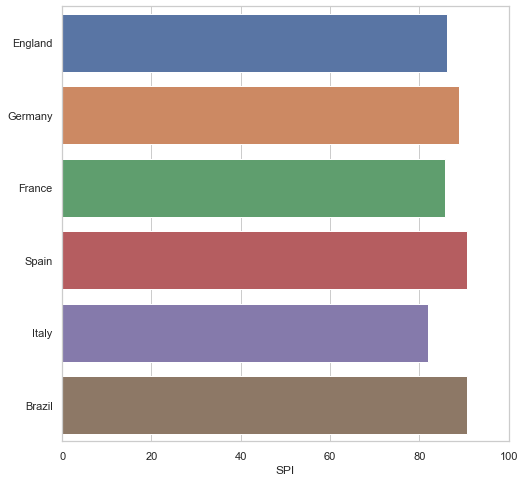

In [4]:
nations = ['England',
           'Germany',
           'France',
           'Spain',
           'Italy',
           'Brazil']
# for n in nations:
# plt.figure(figsize=(8, 8))
# for a in leagues:
#     sns.distplot(df_rank[df_rank['league']==a]['spi'], bins=10, kde=True, rug=True,
#                  kde_kws={"lw": 3, "label": a})
# ax.set_xlim([10, 100])
selected = []
for i in nations:
    selected.append(df_intl[df_intl['name']==i]['spi'].iloc[0])

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x=selected, y=nations)
ax.set(xlim=(0, 100), ylabel="",
       xlabel="SPI")

Brazil jumps to be the top. One possible explanation is that most Brazilian soccer stars joins other league, so their league is not so great but their national team is very strong.

# Prediction the SPI using the off, def and league

using Linear, SVM and neural network

## partition training and test

In [5]:
# handle league
from sklearn.preprocessing import OneHotEncoder
league_list = df_rank['league'].unique()
np_a = np.array(league_list).reshape(-1, 1)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np_a)
# print(enc.transform(np.array(leagues).reshape(-1, 1)).toarray())

# normalize feature and label
from sklearn.preprocessing import normalize
# X : off, def, league
# y: spi
num = [] 
l = []
y = []

for i in range(df_rank.shape[0]):
    num.append([df_rank.iloc[0,4], df_rank.iloc[0,5]])
    l.append(df_rank.iloc[0,3])
    y.append(df_rank.iloc[0,6])

np_num = normalize(np.array(num))
np_l = enc.transform(np.array(l).reshape(-1, 1)).toarray()
X = np.concatenate((np_num, np_l), axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27) # fix random state


## using linear regression

In [6]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
print(reg.coef_)
print(reg.intercept_)
reg_pred_train = reg.predict(X_train)
reg_pred_test = reg.predict(X_test)

from sklearn.metrics import mean_squared_error
print("train error: " + str(mean_squared_error(y_train, reg_pred_train)))
print("test error:  " + str(mean_squared_error(y_test, reg_pred_test)))

[ 2.39162719 -0.23690647  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
92.87150281848112
train error: 0.0
test error:  0.0


Seems that the league has no effect in the linear regression model.

## using SVM

In [7]:
from sklearn import svm
clf = svm.SVR(gamma='scale')
clf.fit(X_train, y_train) 
clf_pred_train = clf.predict(X_train)
clf_pred_test = clf.predict(X_test)

print("train error: " + str(mean_squared_error(y_train, clf_pred_train)))
print("test error:  " + str(mean_squared_error(y_test, clf_pred_test)))

train error: 0.0
test error:  0.0


## using neural network

In [8]:
from sklearn.neural_network import MLPRegressor
NN = MLPRegressor(learning_rate='adaptive', learning_rate_init=0.01)
NN.fit(X_train, y_train)

NN_pred_train = NN.predict(X_train)
NN_pred_test = NN.predict(X_test)
print("train error: " + str(mean_squared_error(y_train, NN_pred_train)))
print("test error:  " + str(mean_squared_error(y_test, NN_pred_test)))

train error: 3.743783664611153e-05
test error:  3.7437836646111536e-05


# Prediction the SPI using the off, def for national team

Since the previous result shows that the league does't matter that much, we are going to verify the same observation holds for national team.

In [9]:
# normalize feature and label
from sklearn.preprocessing import normalize
# X : off, def, league
# y: spi
num1 = [] 
yy = []

for i in range(df_intl.shape[0]):
    num1.append([df_intl.iloc[0,3], df_intl.iloc[0,4]])
    yy.append(df_intl.iloc[0,5])

XX = normalize(np.array(num1))

from sklearn.model_selection import train_test_split
XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size=0.3, random_state=27) # fix random state



In [10]:
reg_intl = LinearRegression().fit(XX_train, yy_train)
print(reg_intl.coef_)
print(reg_intl.intercept_)
reg_intl_pred_train = reg_intl.predict(XX_train)
reg_intl_pred_test = reg_intl.predict(XX_test)

print("train error: " + str(mean_squared_error(yy_train, reg_intl_pred_train)))
print("test error:  " + str(mean_squared_error(yy_test, reg_intl_pred_test)))

[-27.30666667 -20.48      ]
121.1669942454176
train error: 0.0
test error:  0.0
